# Operator scaling
Consider an operator $T:\mathbb{R}^{d\times d}\to\mathbb{R}^{d\times d}$ defined by an $m$-tuple of $d\times d$ matrices $(A_j)_{j=1}^m$: $T(X) = \sum_{i=1}^m A_iXA_i^T$. The problem of operator scaling consists in finding $n\times n$ matrices $X$ and $Y$ such that if $\hat A_i := Y^{-1}A_iX$, then $\sum_{i=1}^m \hat A_i \hat A_i^T = \sum_{i=1}^m \hat A_i^T \hat A_i=  I_d$. 

Such problem is of extreme interest in theoretical computer science (see Garg et al. 2018), and has applications in algebraic complexity~(polynomial identity testing), invariant theory (quiver representations), analysis (computation of Brascamp-Lieb constants) and physics (quantum information). Gurvitz in 2004 showed that one can solve operator scaling by computing the capacity of $T$, i.e. by finding 
$$\text{argmin}_{X\in\mathcal{S}^{++}(d)}\frac{\det(T(X))}{\det(X)}.$$
This cost is non-convex in $\mathbb{R}^{d\times d}$, but its logarithm is geodesically convex on $\mathcal{S}^{++}(d)$ (see the book by Vishnoi). Recently, Allen-Zhu et al. (2018) were able to exploit this property to design a competitive second-order Riemannian optimizer to solve operator scaling. Here, we instead test the performance of accelerated \textit{first-order} methods. 

In [162]:
#libraries to import
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt 
from scipy.linalg import sqrtm, logm, expm
from utils import random_psd, karcher_mean
from geometric_optimizers import RGD_optimizer, RAGD_optimizer,RAGDsDR_optimizer
from pymanopt.manifolds import PositiveDefinite
import torch
import time
%config InlineBackend.figure_format = 'svg'

### Hyperparameters for problem definition and solution

In [163]:
# problem hyperparameters
seed = 41 #for reproducibility
d = 100 #problem dimension
m = 2 #number of matrices for the definition of T

# algorithm hyperparameters
N = 1000 #number of iterations for optimizers and Gurvitz algorithm
line_search_iterations = 10

### Problem definition and numerical solution

In [164]:
np.random.seed(seed)
A = np.random.randint(5, size=(d,d,m)).astype(float) #list of Kraus matrices to define the operator T

def T(X,B):
    L = 0*B[:,:,0]
    for i in range(m): L += np.dot(B[:,:,i],np.dot(X,B[:,:,i].T))
    return L

def T_star(X,B):
    L = 0*B[:,:,0]
    for i in range(m): L += np.dot(B[:,:,i].T,np.dot(X,B[:,:,i]))
    return L

def right_normalization(B): 
    C = np.zeros((d,d,m))
    N = sqrtm(la.inv(T_star(np.identity(d),B)))
    for i in range(m): C[:,:,i]=np.dot(B[:,:,i],N)
    return C
        
def left_normalization(B):
    C = np.zeros((d,d,m))
    N = sqrtm(la.inv(T(np.identity(d),B)))
    for i in range(m): C[:,:,i]=np.dot(N,B[:,:,i])
    return C

#normalizing the operator T using algorithm by Gurvitz https://arxiv.org/abs/1607.06711
print('Computing numerical solution ...')
A_gurvitz = []
A_gurvitz.append(A)
for i in range(N-1): #1.9344748001941225e-08
    A_gurvitz.append(left_normalization(right_normalization(A_gurvitz[-1])))
A_sol = A_gurvitz[-1]

Computing numerical solution ...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


### Manifold initialization

In [165]:
M = PositiveDefinite(d)  

def cost(X): return np.log(la.det(T(X,A)))-np.log(la.det(X))

#formula of the Euclidean gradient in page 18 of https://arxiv.org/pdf/1511.03730.pdf
def grad(X): return np.dot(X,np.dot(T_star(la.inv(T(X,A)),A),X)) - X

def exp(X,U): # M.exp(X,U) by manopt is very unstable
    c = la.cholesky(X)
    c_inv = la.inv(c)
    e = expm(np.dot(np.dot(c_inv, U),c_inv.T))
    return np.dot(np.dot(c, e), c.T)

def retr(X,U):
    return X + U + 0.5* np.dot(np.dot(U,la.inv(X)),U)

def log(X,Y): return M.log(X,Y)

def transp(X,Y,U): return M.transp(X,Y,U)

### Optimization  

In [166]:
#initialization
x0 = np.identity(d)
L = 1

#running the optimizers
t1, x1, f1 = RGD_optimizer(N,x0,L,cost,grad,exp)
t3, x3, f3, beta3 = RAGDsDR_optimizer(N,x0,L,cost,grad,exp,log,transp,line_search_iterations)
t4, x4, f4, beta4 = RAGDsDR_optimizer(N,x0,L,cost,grad,exp,log,transp,-1)

#solution to be the best capacity estimate we have, for simplicity
capacity = np.min([f1,f3,f4]) 
x_star = x3[-1]/(la.det(x3[-1])**(1/d)) #matrix that achieves the capacity of T

Running Riemannian GD...
Running Riemannian AGDsDR(linesearch)...
Running Riemannian AGDsDR(no linesearch)...


### Sanity check
Since we are not directly solving operator scaling, but minimizing the capacity, we have to make sure our solution actually has the desired properties (i.e. that we found a doubly stochastic scaling)

In [167]:
def from_capacity_to_solution(B,x):
    C = np.zeros((d,d,m))
    N = sqrtm(la.inv(T(x,B)))
    for i in range(m): C[:,:,i]=np.dot(N,np.dot(B[:,:,i],sqrtm(x)))
    return C

def ds(B): #distance to double stochasticity (Def 2.9 in https://arxiv.org/abs/1607.06711)
    I = np.identity(d)
    return np.trace(np.dot(T(I,B)-I,T(I,B)-I)) + np.trace(np.dot(T_star(I,B)-I,T_star(I,B)-I))

A_star = from_capacity_to_solution(A,x_star)
print('Distance to double stochasticity via optimization: '+str(ds(A_star)))
print('Distance to double stochasticity via Gurvitz algorithm: '+str(ds(A_sol)))
print('Both values should be very small.')

Distance to double stochasticity via optimization: 1.8930111722822746e-13
Distance to double stochasticity via Gurvitz algorithm: 3.9918510098625957e-07
Both values should be very small.


### Plotting the results (function value)

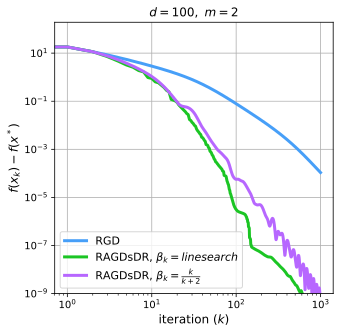

In [168]:
fig, ax = plt.subplots(figsize=(5,5))
ax.loglog(range(N), f1-capacity,label='RGD',linewidth=3, color = '#479FF8')
ax.loglog(range(N), f3-capacity,label=r'RAGDsDR, $\beta_k = linesearch$',linewidth=3, color='#1BC524')
ax.loglog(range(N), f4-capacity,label=r'RAGDsDR, $\beta_k = \frac{k}{k+2}$',linewidth=3, color='#B767FF')
plt.xlabel(r'iteration $(k)$',size=12)
plt.ylabel(r'$f(x_k)-f(x^*)$',size=12,labelpad=-3)
plt.title(r'$d = %d, \ m= %d$'%(d,m))
ax.grid()
ax.legend(fontsize=11)
ax.set_ylim(bottom=1e-9)
plt.show()
filename='results/GURVITZ_seed'+str(seed)+'_d'+str(d)+'_m'+str(m)+'.eps'
fig.savefig(filename, format='eps', dpi=1000)

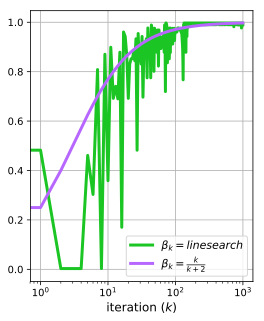

In [169]:
fig, ax = plt.subplots(figsize=(4,5))
ax.semilogx(range(N-2), beta3[0:-2],label=r'$\beta_k=linesearch$',linewidth=3, color='#1BC524')
ax.semilogx(range(N-2), beta4[0:-2],label=r'$\beta_k=\frac{k}{k+2}$',linewidth=3, color='#B767FF')
plt.xlabel(r'iteration $(k)$',size=12)
ax.grid()
ax.legend(fontsize=11)
plt.show()
filename='results/GURVITZ_beta_seed'+str(seed)+'_d'+str(d)+'_m'+str(m)+'.eps'
fig.savefig(filename, format='eps', dpi=1000)

### Plotting the result (distance to doubly-stochastic)

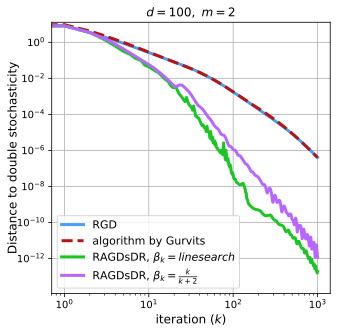

In [174]:
ds1 = np.zeros((N,1))
ds3 = np.zeros((N,1))
ds4 = np.zeros((N,1))
ds_gurvitz = np.zeros((N,1))
for i in range(N): 
    ds1[i] = ds(from_capacity_to_solution(A,x1[i]))
    ds3[i] = ds(from_capacity_to_solution(A,x3[i]))
    ds4[i] = ds(from_capacity_to_solution(A,x4[i]))
    ds_gurvitz[i] = ds(A_gurvitz[i])

fig, ax = plt.subplots(figsize=(5,5))
ax.loglog(range(N), ds1,label='RGD',linewidth=3, color = '#479FF8')
ax.loglog(range(N), ds_gurvitz,'--',label='algorithm by Gurvits',linewidth=3, color = '#B71515')
ax.loglog(range(N), ds3,label=r'RAGDsDR, $\beta_k = linesearch$',linewidth=3, color='#1BC524')
ax.loglog(range(N), ds4,label=r'RAGDsDR, $\beta_k = \frac{k}{k+2}$',linewidth=3, color='#B767FF')
plt.xlabel(r'iteration $(k)$',size=12)
plt.ylabel(r'Distance to double stochasticity',size=12,labelpad=-2)
plt.title(r'$d = %d, \ m= %d$'%(d,m))
ax.grid()
ax.legend(fontsize=11)
ax.set_ylim(top=13)
plt.show()
filename='results/GURVITZ_ds_seed'+str(seed)+'_d'+str(d)+'_m'+str(m)+'.eps'
fig.savefig(filename, format='eps', dpi=1000)